Introduction

This analysis involves the prediction of violent crime in the UK, with the aim of determining levels of violent crime 
during the lock down period. Data used in the study was obtained from the UK Police official street level 
crime data. An attempt will be made at answering a few component questions.

Questions:
1.	What crime categories does the Police data use?
2.	Have the same categories been used consistently?
3.	Are levels of violent crime constant, increasing, or decreasing
4.	Using data prior to the first lockdown predict violent crime levels for April 2020
5.	Compare predicted crime levels with actuals, and so determine whether significant changes to violent crime occurred
6.	The Leicester region was put in a local lockdown in July 2020. Verify your findings (if any) with respect to that region only.

To answer the above questions, analysis and forecasting wil be carried out on the dataset. However, since the study is focused on violent crime, the dataset will be examined and the data of interest extracted through subsetting. This data will then be converted and decomposed to reveal trends and seasonality in the dataset. Then it will be tested for stationarity and transformed if required. Once certified stationary, training and fitting of model will be carried out in order to make predictions.

In [ ]:
#Importing libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages
import itertools

import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

import statsmodels.api as sm

In [2]:
from pyspark import SparkFiles
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import count, avg, sum, col, to_date

Creating Spark Context with Spark Configuration and confirming Spark Context is available

In [3]:
spark = SparkSession\
.builder\
.appName("Python Spark app")\
.getOrCreate()

sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Python Spark app>

Getting the data and uploading it

In [4]:
vc_df = spark.read.csv('Sample_1pc_Data.csv', header=True, inferSchema=True)

In [5]:
vc_df.printSchema()

root
 |-- Crime ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)



In [39]:
vc_df.head()

Row(Crime ID=None, Month='2010-12', Reported by='Avon and Somerset Constabulary', Falls within='Avon and Somerset Constabulary', Longitude=-2.345526, Latitude=51.398948, Location='On or near Daffords Buildings', LSOA code='E01014409', LSOA name='Bath and North East Somerset 004A', Crime type='Anti-social behaviour', Last outcome category=None, Context=None)

In [7]:
vc_df.show()

+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|Crime ID|  Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|          Crime type|Last outcome category|Context|
+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|    null|2010-12|Avon and Somerset...|Avon and Somerset...|-2.345526|51.398948|On or near Daffor...|E01014409|Bath and North Ea...|Anti-social behav...|                 null|   null|
|    null|2010-12|Avon and Somerset...|Avon and Somerset...|-2.398165|51.398925|On or near Symes ...|E01014477|Bath and North Ea...|         Other crime|                 null|   null|
|    null|2010-12|Avon and Somerset...|Avon and Somerset...|-2.349528|51.393991|

Counting the number of entries in the dataframe

In [8]:
print("There are {} records in the sample_1pc dataframe". format(vc_df.count()))

There are 651301 records in the sample_1pc dataframe


In [9]:
vc_df.dtypes

[('Crime ID', 'string'),
 ('Month', 'string'),
 ('Reported by', 'string'),
 ('Falls within', 'string'),
 ('Longitude', 'double'),
 ('Latitude', 'double'),
 ('Location', 'string'),
 ('LSOA code', 'string'),
 ('LSOA name', 'string'),
 ('Crime type', 'string'),
 ('Last outcome category', 'string'),
 ('Context', 'string')]

Crime categories used by the Police data

In [10]:
crime_categories = vc_df.groupby("crime type").count()
crime_categories.show()

+--------------------+------+
|          crime type| count|
+--------------------+------+
|       Bicycle theft|  7349|
|        Public order| 25726|
|               Drugs| 16914|
|Public disorder a...|  2425|
|         Other crime| 25794|
|             Robbery|  6776|
|Criminal damage a...| 53547|
|Theft from the pe...|  7041|
|         Shoplifting| 32354|
|            Burglary| 43382|
|       Violent crime| 16689|
|         Other theft| 52021|
|Possession of wea...|  2758|
|Violence and sexu...|114149|
|       Vehicle crime| 41896|
|Anti-social behav...|202480|
+--------------------+------+



1.	Crime Categories used by the Police data
The schema above reveals the crime categories used by the Police data. In all, 16 crime categories are used.

Determining how often the same categories have been used.

In [11]:
crime_category_ff =(vc_df.select("*")\
    .groupby("month", "crime type")
    .agg(count("crime type").alias("sum")).orderBy("month", ascending = (True)))
crime_category_ff.show(1000)

+-------+--------------------+----+
|  month|          crime type| sum|
+-------+--------------------+----+
|2010-12|            Burglary| 382|
|2010-12|             Robbery|  54|
|2010-12|Anti-social behav...|2052|
|2010-12|         Other crime|1483|
|2010-12|       Vehicle crime| 323|
|2010-12|       Violent crime| 566|
|2011-01|             Robbery|  63|
|2011-01|            Burglary| 475|
|2011-01|         Other crime|1637|
|2011-01|       Vehicle crime| 363|
|2011-01|       Violent crime| 583|
|2011-01|Anti-social behav...|1987|
|2011-02|            Burglary| 421|
|2011-02|             Robbery|  57|
|2011-02|Anti-social behav...|2029|
|2011-02|         Other crime|1671|
|2011-02|       Violent crime| 576|
|2011-02|       Vehicle crime| 347|
|2011-03|            Burglary| 471|
|2011-03|         Other crime|1938|
+-------+--------------------+----+
only showing top 20 rows



2. Determining if same categories have been used consistently.
The schema above shows the crime categories that have been used by the Police department over the years and how often they have been in use. All categories have not been used consistently. For example, the violent crime category stopped being used in April 2013. Instead, the violence and sexual offence catgory was used in its place. 

Subsetting allows us to carryout analysis on area of interest. The dataset contains all crime statitics in the UK since 2010. However, since the study is aimed at predicting violent crimes, the violence and sexual offences crime in crime type will be extracted. 

Violence and sexual offences will be selected instead of violent crime because it is the older category as violent crime category stopped being in use from April 2013.

In [12]:
levels_vcrime = (vc_df.select("*").filter(vc_df['crime type'] == 'Violence and sexual offences')\
    .groupby("month", "crime type")
    .agg(count("crime type").alias("sum")).orderBy("month", ascending = True))
levels_vcrime.show()

+-------+--------------------+----+
|  month|          crime type| sum|
+-------+--------------------+----+
|2013-05|Violence and sexu...| 556|
|2013-06|Violence and sexu...| 593|
|2013-07|Violence and sexu...| 615|
|2013-08|Violence and sexu...| 567|
|2013-09|Violence and sexu...| 534|
|2013-10|Violence and sexu...| 607|
|2013-11|Violence and sexu...| 608|
|2013-12|Violence and sexu...| 622|
|2014-01|Violence and sexu...| 549|
|2014-02|Violence and sexu...| 598|
|2014-03|Violence and sexu...| 630|
|2014-04|Violence and sexu...| 633|
|2014-05|Violence and sexu...| 685|
|2014-06|Violence and sexu...| 778|
|2014-07|Violence and sexu...| 766|
|2014-08|Violence and sexu...| 708|
|2014-09|Violence and sexu...| 749|
|2014-10|Violence and sexu...| 739|
|2014-11|Violence and sexu...| 751|
|2014-12|Violence and sexu...| 781|
|2015-01|Violence and sexu...| 732|
|2015-02|Violence and sexu...| 707|
|2015-03|Violence and sexu...| 838|
|2015-04|Violence and sexu...| 781|
|2015-05|Violence and sexu..

3. Levels of Violent Crime
From the schema above, it is quite obvious that levels of violence and sexual offences have been on the increase over the years. From 556 as at May 2013 to 1722 in May 2021. Although there are times when there are slight increase and decrease. The data will be visualized later on for better understanding and to determine if there are trends and seasonality. In all, violence and sexual offeces have increased over the years.

In [13]:
levels_vcrime.schema

StructType(List(StructField(month,StringType,true),StructField(crime type,StringType,true),StructField(sum,LongType,false)))

In [14]:
levels_vcrime.count()

97

4. Using data prior to the first lockdown to predict violent crime levels for April 2020
Before building a model for forecasting, there are several measures that needs to be taken. First is converting spark dataframe to pandas dataframe. Pandas is common used package in python that provides flexible data structures.

In [15]:
levels_vcrime1 = levels_vcrime.toPandas()
levels_vcrime1

,month,crime type,sum
0,2013-05,Violence and sexual offences,556
1,2013-06,Violence and sexual offences,593
2,2013-07,Violence and sexual offences,615
3,2013-08,Violence and sexual offences,567
4,2013-09,Violence and sexual offences,534
...,...,...,...
92,2021-01,Violence and sexual offences,1434
93,2021-02,Violence and sexual offences,1319
94,2021-03,Violence and sexual offences,1669
95,2021-04,Violence and sexual offences,1540


After converting the Spark dataframe to pandas, next we convert the Pandas dataframe to be time indexed. The index is automatically generated

In [16]:
levels_vcrime1.month = levels_vcrime1.month.astype('datetime64[ns]')
levels_vcrime2 = levels_vcrime1.set_index(pd.to_datetime(levels_vcrime1.month))

In [17]:
levels_vcrime2.index

DatetimeIndex(['2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01',
               '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
      

Visualizing the Data:

Using the matplotlib package the data is visualized for ease in viewing the mean. The data is plotted as a lineplot and displayed below.

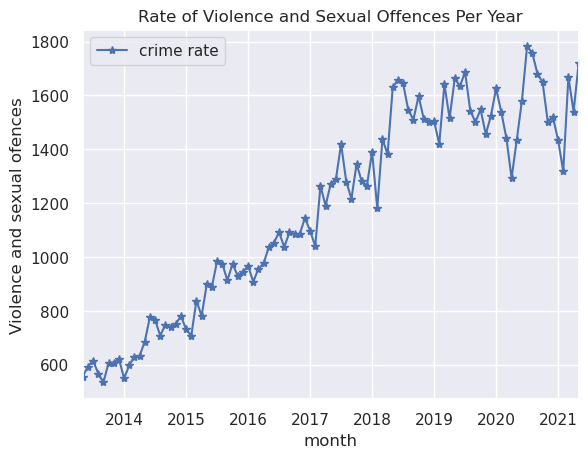

In [18]:
plt.figsize = (20, 6)
levels_vcrime1.plot(y ='sum', x ='month', marker='*', linestyle = '-',\
        label = 'crime rate',
        title = 'Rate of Violence and Sexual Offences Per Year')
plt.ylabel('Violence and Sexual Offences')

plt.show()

From the plot above, the timeseries exhibits some patterns. One can see the noise in time series going up. There is an increasing trend with no clear pattern of seasonal or cyclical changes. Therefore, there is need to decompose the data to view the complexity behind the lineplot.

Decomposition
The data is decomposed using the Spark modules timeseries analysis. Since the timeseries data shows some patterns, it is decomposed into several parts- residual, seasonal and trend that represents each pattern category. Decomposing helps for improved understanding of the time series and improved forecast accuracy.

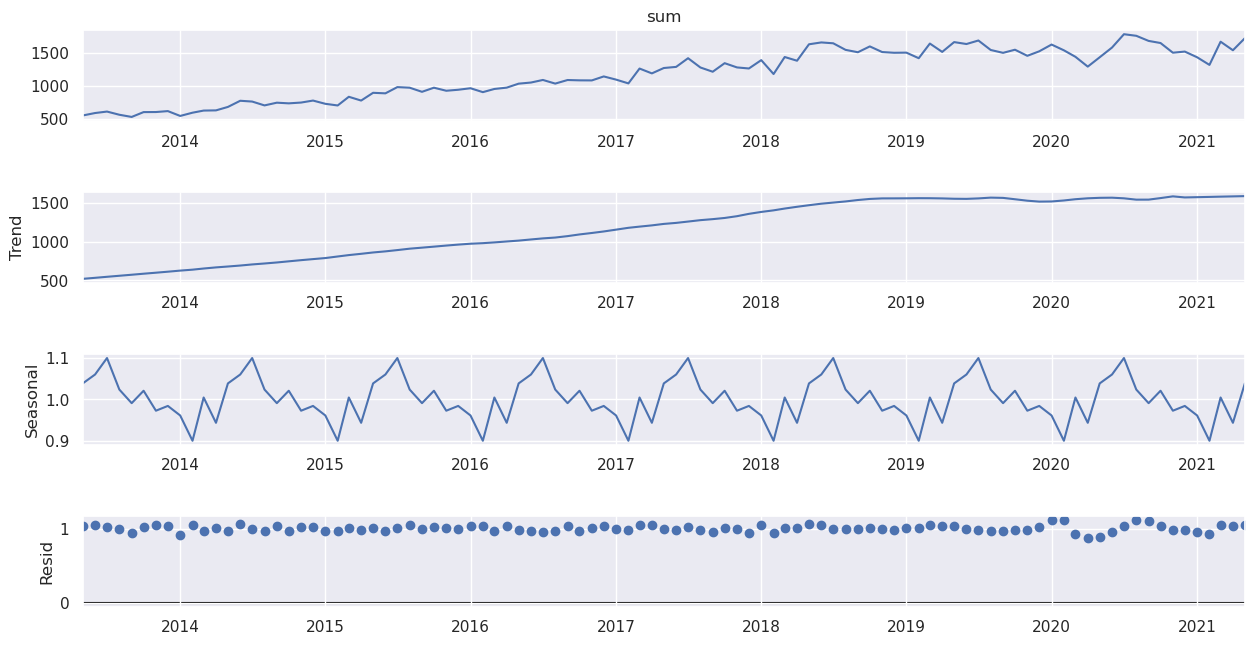

In [19]:
decomposition = sm.tsa.seasonal_decompose(levels_vcrime2['sum'], model='multiplicative',extrapolate_trend='freq')
fig = decomposition.plot()
fig.set_size_inches(14,7)
plt.show()

A careful look at the data reveals that it has an increasing trend and a yearly seasonality. Next, a statuionarity test is carried out to determine if the dataset is stationary or non-stationary.

Test for Stationarity

Most statistical approaches e.g. time series forecasting models, require data stationarity which means that the mean and variance does not change overtime. To test for stationarity of the timeseries, two popular methpds are applied-visualization and the Augumented Dickey-Fuller (ADF) Test. The data is first visualized to determine if the standard deviation and mean changes overtime. The rolling statistics (mean and variance) is graphed and once the pattern is seen then it is transformed using the Augumented Dicker-Fuller (ADF) test.

In [20]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    plt.clf()
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()
    plt.show()

<Figure size 640x480 with 0 Axes>

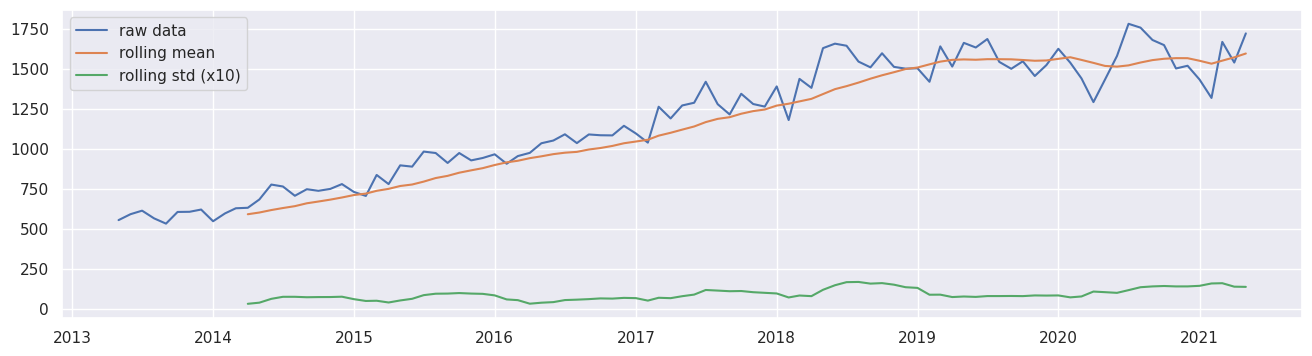

In [21]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(levels_vcrime2['sum'],'raw data')

The standard deviation does not change much and there seems to be some changes in the mean overtime. However, conclusion cannot be drawn by just viewing the graph. therefore, another test for stationarity (ADF test) is carried out. 

The ADF test is carried out to determine the probability of stationarity in the timeseries. This is done by comparing the p-value with the critical values then hypothesis testing done. At various levels of confidence, the ADF test can determine a statioary and non-stationary data. If the non-stationary then transformations will be applied and a re-test executed. If stationary then the data can be used for predictions.

In [22]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))
      

In [23]:
ADF_test(levels_vcrime2['sum'],'raw data')

 > Is the raw data stationary ?
Test statistic = -1.868
P-value = 0.347
Critical values :
	1%: -3.510711795769895 - The data is not stationary with 99% confidence
	5%: -2.8966159448223734 - The data is not stationary with 95% confidence
	10%: -2.5854823866213152 - The data is not stationary with 90% confidence


Since the data is not stationary, a number of approaches will be applied to stationarize the data. Detrending and a combination of detrending and differencing. 

Detrending is needed to remove the effects of trend in the timeseries. 

<Figure size 640x480 with 0 Axes>

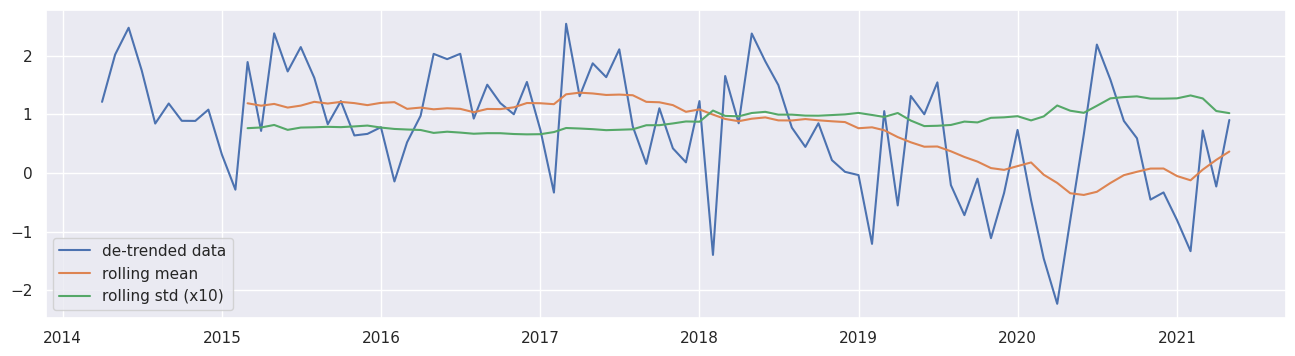

 > Is the de-trended data stationary ?
Test statistic = -0.826
P-value = 0.811
Critical values :
	1%: -3.5219803175527606 - The data is not stationary with 99% confidence
	5%: -2.9014701097664504 - The data is not stationary with 95% confidence
	10%: -2.58807215485756 - The data is not stationary with 90% confidence


In [24]:
# Detrending
y = levels_vcrime2['sum']
y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

Re-testing reveals that the data is still non-stationary after detrending. The same stationary white noise is present. Next a combination of tranformation method- detrending and differencing is used to stationarize the data and remove trend and seasonality from the time series.

<Figure size 640x480 with 0 Axes>

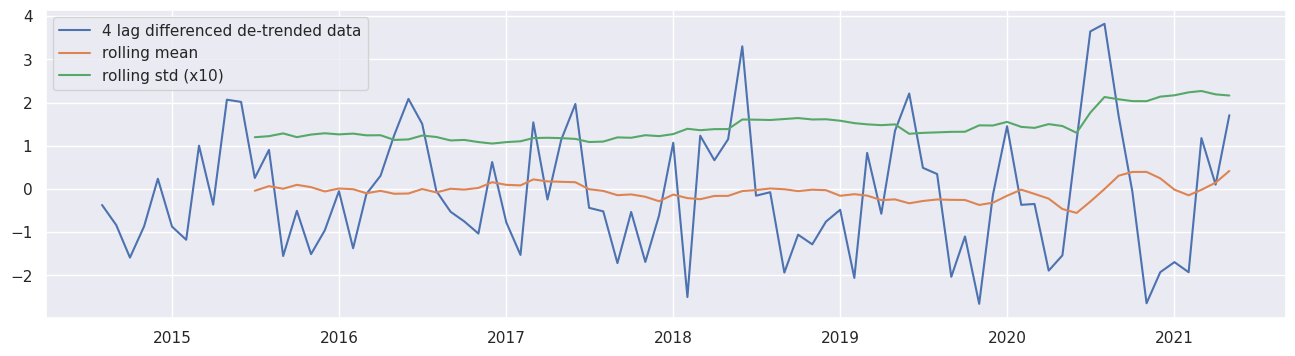

 > Is the 4 lag differenced de-trended data stationary ?
Test statistic = -4.980
P-value = 0.000
Critical values :
	1%: -3.5232835753964475 - The data is  stationary with 99% confidence
	5%: -2.902030597326081 - The data is  stationary with 95% confidence
	10%: -2.5883710883843123 - The data is  stationary with 90% confidence


In [25]:
# Detrending + Differencing

y_12lag_detrend =  y_detrend - y_detrend.shift(4)

test_stationarity(y_12lag_detrend,'4 lag differenced de-trended data')

ADF_test(y_12lag_detrend,'4 lag differenced de-trended data')

The data is stationary and is ready to be used for predictions. 

Training and Testing Datasets

A model is built to carryout predictions. In building the model, it important to split the dataset into at least two parts. This is important for performance evaluation. The chosen forecasting model is SARIMA.

Hence, the dataset is split into two (training and test data) as shown below.

In [26]:

y_to_train = y_12lag_detrend[:'2019-12-01'] # dataset to train
y_to_test = y_12lag_detrend['2020-01-01': ] # last X months for test  
#predict_date = len(y_12lag_detrend) - len(y_12lag_detrend[:'2019-02-01']) # the number of data points for the test set
y_to_val = y_to_test

In [27]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

p = d = q = range(0, 2)
seasonal_period = 12
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


To get the best predictions, the values of the SARIMA(p,d,q)m that optimizes the metric of interest was found as shown above.

Next, a grid search is carried out. The grid search uses the Akaike Information Criterion (AIC) value as an evaluation metric. This measures how well the model fits the data. The aim here is to select a combinition with the lowest AIC value.

In [28]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod =\
            sm.tsa.statespace.SARIMAX(y_to_train,
                                      order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12- AIC:{}'.format(param, param_seasonal, results.aic))
        except Exception as ex:
            print(ex)
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12- AIC:218.22489126775443
ARIMA(0, 0, 0)x(0, 0, 1, 12)12- AIC:198.62041057938166
ARIMA(0, 0, 0)x(0, 1, 0, 12)12- AIC:327.68854430237343
ARIMA(0, 0, 0)x(0, 1, 1, 12)12- AIC:306.3624641223312
ARIMA(0, 0, 0)x(1, 0, 0, 12)12- AIC:175.35966212340006
ARIMA(0, 0, 0)x(1, 0, 1, 12)12- AIC:158.37898175936726
ARIMA(0, 0, 0)x(1, 1, 0, 12)12- AIC:306.0072890767123
ARIMA(0, 0, 0)x(1, 1, 1, 12)12- AIC:306.15777616652394
ARIMA(0, 0, 1)x(0, 0, 0, 12)12- AIC:216.9904436735116
ARIMA(0, 0, 1)x(0, 0, 1, 12)12- AIC:200.09824598241755
ARIMA(0, 0, 1)x(0, 1, 0, 12)12- AIC:326.3001666796371
ARIMA(0, 0, 1)x(0, 1, 1, 12)12- AIC:306.09408098239123
ARIMA(0, 0, 1)x(1, 0, 0, 12)12- AIC:176.75880558550077
ARIMA(0, 0, 1)x(1, 0, 1, 12)12- AIC:159.54102330338378
ARIMA(0, 0, 1)x(1, 1, 0, 12)12- AIC:307.0840370255821
ARIMA(0, 0, 1)x(1, 1, 1, 12)12- AIC:306.67734094145834
ARIMA(0, 1, 0)x(0, 0, 0, 12)12- AIC:256.1343504246763
ARIMA(0, 1, 0)x(0, 0, 1, 12)12- AIC:246.95235656666964
ARIMA(0, 1, 0)x(

All possible variable combinations was tested by the grid search and sets with the lowest AIC were printed out. 

Train and fit the model
The method will be used to fit our model and comapare results since it choses the best parameters.

In [29]:
order = (0, 0, 0) #Using Values from the previous step
seasonal_order = (1, 0, 1, 12)
model = sm.tsa.statespace.SARIMAX(y_to_train,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_invertibility=False)
results = model.fit()

Next to ensure that the assumptions made by the model have not been violated and there are no unsual behavior, the plot_diagonistics function is used. 

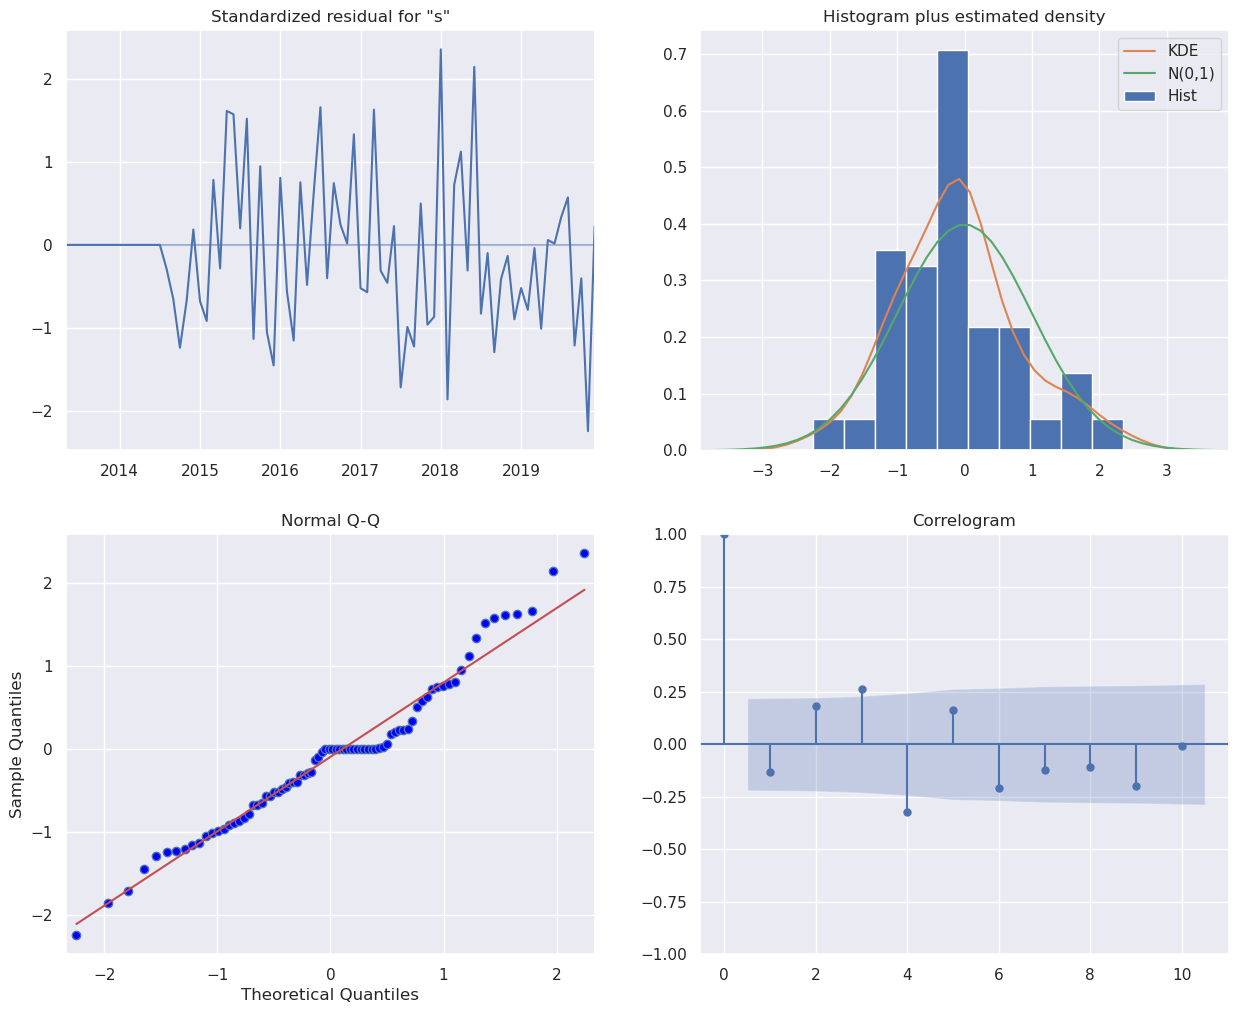

In [30]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

The plot on the top left reveals the residuals overtime. There are no obvious seasonality. In the plot at the top right, we are interested in the KDE line and want to see it closely follow the N(0,1) line to illustrate the normal distribution of the residuals. This line is a notation for a mean of 0 and a standard deviation of 1.


Now that the model is ready. We forecast future values based on past events. We will be predicting violence and sexual offences crime level using the SARIMA model. Afterwhich we compare predicted crime levels with actuals to determine whether they were significant changes to violent crime. To achieve this, the observed data and forecast data will be plotted showing a 95% confidence interval.

In [31]:
pred_uc = results.get_forecast(steps=12)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
pred_ci = pred_uc.conf_int()

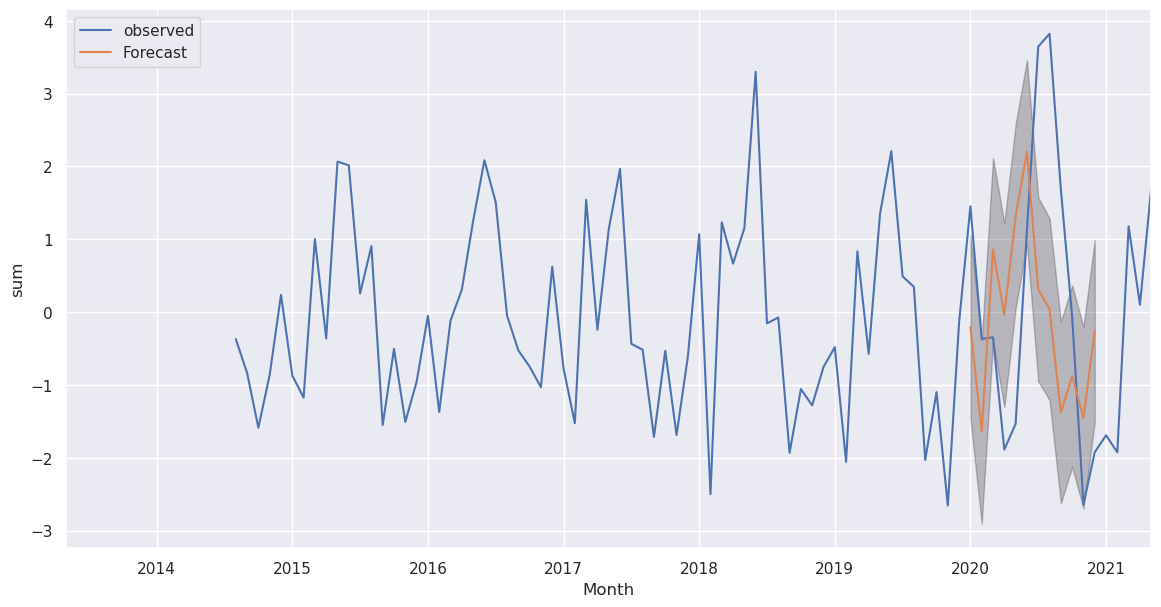

In [32]:
ax = y_12lag_detrend.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Month')
ax.set_ylabel(y_12lag_detrend.name)

plt.legend()
plt.show()

The red line in the graph above  represents the forecasted data which is based on the built model. It is the average forecasted value for each month while the blue line actual values. The gray area represents 95% confidence interval. We are 95% confident that violent crime will fall within this range. However, the actual fell slightly outside the range. There are several factors- unforeseen and uncontrolled that influences actual data and this accounts for the discrepancies. For example outcome of the covid-19 restrictions is an examples of such factor.
Comparing the actual and forecasted values, it is quite obvious that the lockdown may have influenced the increase in violence and sexual offences in UK. The predictions made from previous data revealed a normal trend in the increase and decrease in crime level. While the actual values show an increase in crime levels in the lockdown year.

In [33]:
# Produce the forcasted tables 
pm = pred_uc.predicted_mean.reset_index()
pm.columns = ['month','predicted_mean']
pci = pred_ci.reset_index()
pci.columns = ['month','lower bound','upper bound']
final_table = pm.join(pci.set_index('month'), on='month')

In [34]:
final_table.head(12)

,month,predicted_mean,lower bound,upper bound
0,2020-01-01,-0.20574133,-1.46866718,1.05718452
1,2020-02-01,-1.64261141,-2.90553726,-0.37968556
2,2020-03-01,0.85523906,-0.40768680,2.11816491
3,2020-04-01,-0.03988992,-1.30281577,1.22303593
4,2020-05-01,1.31606422,0.05313837,2.57899008
5,2020-06-01,2.19918667,0.93626082,3.46211252
6,2020-07-01,0.31306126,-0.94986459,1.57598711
7,2020-08-01,0.03969512,-1.20806922,1.28745946
8,2020-09-01,-1.37942217,-2.62718651,-0.13165783
9,2020-10-01,-0.88121536,-2.12897970,0.36654898


In [35]:
y_to_test.head(12)

month
2020-01-01    1.45292540
2020-02-01   -0.36618165
2020-03-01   -0.34566848
2020-04-01   -1.88779913
2020-05-01   -1.53448324
2020-06-01    1.11820027
2020-07-01    3.64543000
2020-08-01    3.82184895
2020-09-01    1.68733381
2020-10-01   -0.06298547
2020-11-01   -2.64271714
2020-12-01   -1.92349319
Name: sum, dtype: float64

6.	Determinig the effects of lockdown in the Leicester region 
To determine the effects on lockdown in the region, a new dataframe is created one in which we subset the category (violence and sexual offence) into. Afterwhich, the data is viewed. For better understanding the data is then visualized and analysis made.

In [36]:
leicester_df = (vc_df
.select('Month', 'Crime type','LSOA name')
.filter((vc_df['Crime type'] == 'Violence and sexual offences') & vc_df['LSOA name'].startswith('Leicester'))
.groupby("Month", "Crime type")
.agg(count("Crime type").alias("SUM"))
.orderBy("Month", ascending = True)
)

leicester_df.show(truncate = False)

+-------+----------------------------+---+
|Month  |Crime type                  |SUM|
+-------+----------------------------+---+
|2013-05|Violence and sexual offences|4  |
|2013-06|Violence and sexual offences|10 |
|2013-07|Violence and sexual offences|6  |
|2013-08|Violence and sexual offences|4  |
|2013-09|Violence and sexual offences|1  |
|2013-10|Violence and sexual offences|4  |
|2013-11|Violence and sexual offences|10 |
|2013-12|Violence and sexual offences|6  |
|2014-01|Violence and sexual offences|5  |
|2014-02|Violence and sexual offences|5  |
|2014-03|Violence and sexual offences|4  |
|2014-04|Violence and sexual offences|4  |
|2014-05|Violence and sexual offences|6  |
|2014-06|Violence and sexual offences|7  |
|2014-07|Violence and sexual offences|8  |
|2014-08|Violence and sexual offences|6  |
|2014-09|Violence and sexual offences|9  |
|2014-10|Violence and sexual offences|7  |
|2014-11|Violence and sexual offences|3  |
|2014-12|Violence and sexual offences|4  |
+-------+--

In [37]:
leicester_df.count()

97

In [55]:
leicester_df.show(100)

+-------+--------------------+---+
|  Month|          Crime type|SUM|
+-------+--------------------+---+
|2013-05|Violence and sexu...|  4|
|2013-06|Violence and sexu...| 10|
|2013-07|Violence and sexu...|  6|
|2013-08|Violence and sexu...|  4|
|2013-09|Violence and sexu...|  1|
|2013-10|Violence and sexu...|  4|
|2013-11|Violence and sexu...| 10|
|2013-12|Violence and sexu...|  6|
|2014-01|Violence and sexu...|  5|
|2014-02|Violence and sexu...|  5|
|2014-03|Violence and sexu...|  4|
|2014-04|Violence and sexu...|  4|
|2014-05|Violence and sexu...|  6|
|2014-06|Violence and sexu...|  7|
|2014-07|Violence and sexu...|  8|
|2014-08|Violence and sexu...|  6|
|2014-09|Violence and sexu...|  9|
|2014-10|Violence and sexu...|  7|
|2014-11|Violence and sexu...|  3|
|2014-12|Violence and sexu...|  4|
|2015-01|Violence and sexu...|  4|
|2015-02|Violence and sexu...|  5|
|2015-03|Violence and sexu...|  5|
|2015-04|Violence and sexu...|  5|
|2015-05|Violence and sexu...|  2|
|2015-06|Violence an

In [41]:
leicester_vc = leicester_df.toPandas()
leicester_vc

,Month,Crime type,SUM
0,2013-05,Violence and sexual offences,4
1,2013-06,Violence and sexual offences,10
2,2013-07,Violence and sexual offences,6
3,2013-08,Violence and sexual offences,4
4,2013-09,Violence and sexual offences,1
...,...,...,...
92,2021-01,Violence and sexual offences,17
93,2021-02,Violence and sexual offences,11
94,2021-03,Violence and sexual offences,10
95,2021-04,Violence and sexual offences,14


In [44]:
leicester_vc.Month = leicester_vc.Month.astype('datetime64[ns]')
leicester_vc1 = leicester_vc.set_index(pd.to_datetime(leicester_vc.Month))

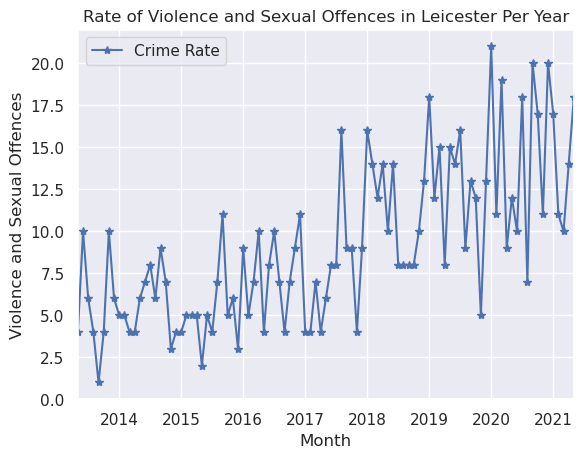

In [54]:
plt.figsize = (15, 3)
leicester_vc1.plot(y ='SUM', x ='Month', marker='*', linestyle = '-',\
        label = 'Crime Rate',
        title = 'Rate of Violence and Sexual Offences in Leicester Per Year')
plt.ylabel('Violence and Sexual Offences')

plt.show()

The graph above shows an increase in violence and sexual offences overtime in Leicester region. Atlthough it reached its peak in January 2020 which before the lockdown in July 2020. Comparing this with the analysis made earlier on the overall increase in crime levels. It is somewhat contradictory because it seems the lockdown had minimal effects on crime levels in Leicester region.

Conclusion

The study aimed to determining levels of violent crime in the UK especially during the lock down period. From predictions made, there was no significant increase in violence and sexual offence crime in the UK during the lockdown. However, the actual values revealed an increase in violence and sexual crime in the UK during the lockdown. Hence, it is safe to say that the lockdown contributed to increase in crime levels. However, data from Leicester region suggest otherwise as it revealed an increase in violence and sexual crime before the lockdown. Therefore more studies can be conducted to determine the reason behind this.